In [1]:
import numpy as np
import pandas as pd

np.__version__, pd.__version__

%matplotlib inline
%load_ext rpy2.ipython

import warnings
warnings.filterwarnings('ignore')

#pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 50)

In [2]:
#Load data

file1 = pd.read_csv("Data/survey/File1.csv", header="infer", index_col=False)
file2 = pd.read_csv("Data/survey/File2.csv")

In [11]:
#encode response

from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
file1['resp'] = enc.fit_transform(file1.SPENDINGRESPONSE)
resp = file1[['ID','resp']]

In [ ]:
resp.count_values()

In [ ]:
resp.head()

In [12]:
#correct feature datatypes

feat = file2
#assume no problem with type conversion, with more time I would be more careful
cont_var = ['f2']
feat[cont_var] = feat[cont_var].astype("float64")
categ_var = ['f93', 'f94']
feat[categ_var] = feat[categ_var].astype("category")

#assume no problem with type conversion, with more time I would be more careful
categ = feat.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
feat2 = feat.loc[:, feat.dtypes != np.object]
feat3 = feat2.join(categ)
feat3.shape    #chk: 24 + 126

(20000, 149)

In [14]:
# merge, under-sample, train-test split

Survey = resp.merge(feat3, left_on="ID", right_on="ID", how="left")
Survey.drop(columns=['ID'])

LessGov = Survey.loc[Survey.resp==1,].sample(n=6169, replace=True, random_state=1)
MoreGov = Survey.loc[Survey.resp==0,]
Survey = pd.concat([LessGov, MoreGov]).reset_index(drop=True)

y_set = Survey[['resp']] 
X_set = Survey.drop(columns=['ID','resp'])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_set, y_set, test_size=0.2)

In [32]:
#pipeline
#separate encode numeric, categoric
#perform pca
#run randomforest() in cv

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

colname_num = (X_train.loc[:, X_train.dtypes == np.float64]).columns
colname_cat = (X_train.loc[:, X_train.dtypes != np.float64]).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('pca', PCA())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, colname_num),
        ('cat', categorical_transformer, colname_cat)])

In [33]:
#rf_gs.get_params().keys()
#import sklearn
#sorted(sklearn.metrics.SCORERS.keys())

# KNN

In [79]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_jobs=5)
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('knn', knn)])
param_grid = {"knn__n_neighbors": [3, 5, 7],
              'preprocessor__num__pca__n_components': [10, 20, 30]}
knn_gs = RandomizedSearchCV(pipe, param_grid, iid=True, cv=5, scoring="f1", n_iter=20)
knn_gs.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbo...owski',
           metric_params=None, n_jobs=5, n_neighbors=5, p=2,
           weights='uniform'))]),
          fit_params=None, iid=True, n_iter=20, n_jobs=None,
          param_distributions={'knn__n_neighbors': [3, 5, 7]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

In [80]:
# Cross Validation

knn_best = knn_gs.best_estimator_
print(knn_gs.best_params_)
#GridSearchCV: Mean cross-validated score of the best_estimator
#SGDClassifier: Returns the mean accuracy on the given test data and labels
print("Best parameter (CV score=%0.3f):" % knn_gs.best_score_)

{'knn__n_neighbors': 3}
Best parameter (CV score=0.430):


In [81]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix

y_train_pred = knn_gs.predict(X_train)
print( "Confusion matrix: Training")
confusion_matrix(y_train, y_train_pred)

Confusion matrix: Training


array([[9763, 1290],
       [1259, 3688]])

In [82]:
y_pred = knn_gs.predict(X_test)
print( "Confusion matrix: Testing")
confusion_matrix(y_test, y_pred)

Confusion matrix: Testing


array([[2179,  599],
       [ 654,  568]])

In [83]:
# Testing

from sklearn.metrics import accuracy_score

# fraction of correctly classified samples
print( "Accuracy score: %0.3f" % accuracy_score(y_test, y_pred) )

from sklearn.metrics import precision_score, recall_score
print( "Precision score: %0.3f" % precision_score(y_test, y_pred) )             # TP / (TP+FP)
print( "Recall score: %0.3f" % recall_score(y_test, y_pred)   )                 # TP / (TP+FN)

from sklearn.metrics import f1_score
print( "F1 score: %0.3f" % f1_score(y_test, y_pred) )

Accuracy score: 0.687
Precision score: 0.487
Recall score: 0.465
F1 score: 0.476


In [84]:
# Testing

#predictions for outcome labels
#Predict class probabilities for X.  The predicted class probabilities of an input sample are computed as the mean predicted
#class probabilities of the trees in the forest. The class probability of a single tree is the fraction of samples of the same
#class in a leaf.
y_class_prob = knn_gs.predict_proba(X_test)                 # called   predict_proba(), for some classifiers
y_prob = np.asarray( [x[1] for x in y_class_prob], dtype=np.float32)
threshold = 0                                               # set threshold
y_some_digit_pred = (y_prob > threshold)
print( "Average training probability: %0.3f" % np.mean(y_prob) )

#roc auc
from sklearn.metrics import roc_auc_score
print( "Area Under ROC Curve: %0.3f" % roc_auc_score(y_test, y_prob) )

Average training probability: 0.327
Area Under ROC Curve: 0.681


# Logistic Regression

In [62]:
#ref: SGD classifier will have the same loss function as the Logistic Regression but a different solver
from sklearn.linear_model import SGDClassifier

logistic = SGDClassifier(loss='log', penalty='l1', early_stopping=True,
                         max_iter=10000, tol=1e-5, random_state=0)

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('logistic', logistic)
])

param_grid = {
    'preprocessor__num__pca__n_components': [10, 20, 30],
    'logistic__alpha': np.logspace(-4, 4, 5),
}
log_gs = GridSearchCV(pipe, param_grid, iid=True, cv=10, 
                      return_train_score=False,
                     scoring='f1')
log_gs.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbo...dom_state=0, shuffle=True, tol=1e-05,
       validation_fraction=0.1, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=None,
       param_grid={'preprocessor__num__pca__n_components': [10, 20, 30], 'logistic__alpha': array([1.e-04, 1.e-02, 1.e+00, 1.e+02, 1.e+04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='f1', verbose=0)

In [63]:
# Cross Validation

log_best = log_gs.best_estimator_
print(log_gs.best_params_)
#GridSearchCV: Mean cross-validated score of the best_estimator
#SGDClassifier: Returns the mean accuracy on the given test data and labels
print("Best parameter (CV score=%0.3f):" % log_gs.best_score_)

{'logistic__alpha': 0.0001, 'preprocessor__num__pca__n_components': 10}
Best parameter (CV score=0.346):


In [64]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix
y_train_pred = log_gs.predict(X_train)
print( "Confusion matrix: Training")
confusion_matrix(y_train, y_train_pred)

Confusion matrix: Training


array([[7113, 3940],
       [2576, 2371]])

In [65]:
y_pred = log_gs.predict(X_test)
print( "Confusion matrix: Testing")
confusion_matrix(y_test, y_pred)

Confusion matrix: Testing


array([[1810,  968],
       [ 656,  566]])

In [66]:
# Test

from sklearn.metrics import accuracy_score

y_pred = log_gs.predict(X_test)
# fraction of correctly classified samples
print( "Accuracy score: %0.3f" % accuracy_score(y_test, y_pred) )

from sklearn.metrics import precision_score, recall_score
print( "Precision score: %0.3f" % precision_score(y_test, y_pred) )             # TP / (TP+FP)
print( "Recall score: %0.3f" % recall_score(y_test, y_pred)   )                 # TP / (TP+FN)

from sklearn.metrics import f1_score
print( "F1 score: %0.3f" % f1_score(y_test, y_pred) )

Accuracy score: 0.594
Precision score: 0.369
Recall score: 0.463
F1 score: 0.411


In [67]:
# Test

#predictions for outcome labels
#decision_function: Predict confidence scores for samples.  The confidence score for a sample is the signed distance of that
#sample to the hyperplane.
y_prob = log_gs.decision_function(X_test)		        # called   predict_proba(), for some classifiers
threshold = 0											# set threshold
y_some_digit_pred = (y_prob > threshold)
print( "Average training probability: %0.3f" % np.mean(y_prob) )

#roc auc
from sklearn.metrics import roc_auc_score
print( "Area Under ROC Curve: %0.3f" % roc_auc_score(y_test, y_prob) )

Average training probability: -0.769
Area Under ROC Curve: 0.582


# RandomForest

In [73]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=0)

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('rf', rf)
])

param_grid = {
    'preprocessor__num__pca__n_components': [10, 20, 30],
    'rf__n_estimators': [10, 25, 50], 
    'rf__max_depth':np.arange(4, 9)}

rf_gs = GridSearchCV(pipe, param_grid, iid=True, cv=5, return_train_score=False,
                    scoring='f1')
rf_gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbo...ors='warn', n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=None,
       param_grid={'preprocessor__num__pca__n_components': [10, 20, 30], 'rf__n_estimators': [10, 25, 50], 'rf__max_depth': array([4, 5, 6, 7, 8])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='f1', verbose=0)

In [74]:
# Cross Validation

rf_best = rf_gs.best_estimator_
print(rf_gs.best_params_)
#GridSearchCV: Mean cross-validated score of the best_estimator
#SGDClassifier: Returns the mean accuracy on the given test data and labels
print("Best parameter (CV score=%0.3f):" % rf_gs.best_score_)

{'preprocessor__num__pca__n_components': 30, 'rf__max_depth': 8, 'rf__n_estimators': 10}
Best parameter (CV score=0.027):


In [75]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix
y_train_pred = rf_gs.predict(X_train)
print( "Confusion matrix: Training")
confusion_matrix(y_train, y_train_pred)

Confusion matrix: Training


array([[11047,     6],
       [ 4820,   127]])

In [76]:
y_pred = rf_gs.predict(X_test)
print( "Confusion matrix: Testing")
confusion_matrix(y_test, y_pred)

Confusion matrix: Testing


array([[2770,    8],
       [1206,   16]])

In [77]:
# Testing

from sklearn.metrics import accuracy_score

y_pred = rf_gs.predict(X_test)
# fraction of correctly classified samples
print( "Accuracy score: %0.3f" % accuracy_score(y_test, y_pred) )

from sklearn.metrics import precision_score, recall_score
print( "Precision score: %0.3f" % precision_score(y_test, y_pred) )             # TP / (TP+FP)
print( "Recall score: %0.3f" % recall_score(y_test, y_pred)   )                 # TP / (TP+FN)

from sklearn.metrics import f1_score
print( "F1 score: %0.3f" % f1_score(y_test, y_pred) )

Accuracy score: 0.697
Precision score: 0.667
Recall score: 0.013
F1 score: 0.026


In [78]:
# Testing

#predictions for outcome labels
#Predict class probabilities for X.  The predicted class probabilities of an input sample are computed as the mean predicted
#class probabilities of the trees in the forest. The class probability of a single tree is the fraction of samples of the same
#class in a leaf.
y_class_prob = rf_gs.predict_proba(X_test)                  # called   predict_proba(), for some classifiers
y_prob = np.asarray( [x[1] for x in y_class_prob], dtype=np.float32)
threshold = 0                                               # set threshold
y_some_digit_pred = (y_prob > threshold)
print( "Average training probability: %0.3f" % np.mean(y_prob) )

#roc auc
from sklearn.metrics import roc_auc_score
print( "Area Under ROC Curve: %0.3f" % roc_auc_score(y_test, y_prob) )

Average training probability: 0.307
Area Under ROC Curve: 0.665


In [85]:
knn_y_class_prob = knn_gs.predict_proba(X_test)
log_y_prob = log_gs.decision_function(X_test) 
rf_y_class_prob = rf_gs.predict_proba(X_test)

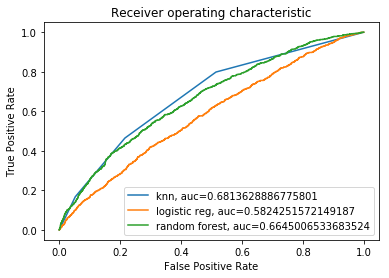

In [86]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

plt.figure(0).clf()

#KNN
y_prob = np.asarray( [x[1] for x in knn_y_class_prob], dtype=np.float32)
fpr, tpr, thresh = metrics.roc_curve(y_test, y_prob)
auc = metrics.roc_auc_score(y_test, y_prob)
plt.plot(fpr,tpr,label="knn, auc="+str(auc))

#LogisticRegression  
y_prob = log_y_prob
fpr, tpr, thresh = metrics.roc_curve(y_test, y_prob)
auc = metrics.roc_auc_score(y_test, y_prob)
plt.plot(fpr,tpr,label="logistic reg, auc="+str(auc))

#RandomForest   
y_prob = np.asarray( [x[1] for x in rf_y_class_prob], dtype=np.float32)
fpr, tpr, thresh = metrics.roc_curve(y_test, y_prob)
auc = metrics.roc_auc_score(y_test, y_prob)
plt.plot(fpr,tpr,label="random forest, auc="+str(auc))


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc=0)